In [280]:

# basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# preprocessing imports
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


In [281]:
df = pd.read_csv("full_data.csv")[["Layout","Powder","PlateID", "Location", "scrap"]]

In [282]:
df.head(3)

,Layout,Powder,PlateID,Location,scrap
0,6X6,Virgin,A,a1,0
1,6X6,Virgin,A,a3,0
2,6X6,Virgin,A,a5,0


In [283]:
df['Layout_Powder_Combo'] = df['Layout'] + '_' + df['Powder']
df['Layout_PlateID_Combo'] = df['Layout'] + '_' + df['PlateID']
df['Location_PlateID_combo'] = df['Location'] + '_' + df['PlateID']
df['Location_Powder_combo'] = df['Location'] + '_' + df['Powder']
df['Location_Powder_combo'] = df['Location'] + '_' + df['Powder']
df['PlateID_Powder_combo'] = df['PlateID'] + '_' + df['Powder']


df.head(3)

,Layout,Powder,PlateID,Location,scrap,Layout_Powder_Combo,Layout_PlateID_Combo,Location_PlateID_combo,Location_Powder_combo,PlateID_Powder_combo
0,6X6,Virgin,A,a1,0,6X6_Virgin,6X6_A,a1_A,a1_Virgin,A_Virgin
1,6X6,Virgin,A,a3,0,6X6_Virgin,6X6_A,a3_A,a3_Virgin,A_Virgin
2,6X6,Virgin,A,a5,0,6X6_Virgin,6X6_A,a5_A,a5_Virgin,A_Virgin


In [284]:
#Splitting original data into train/test
df_train, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['scrap']
)

In [285]:
#Creating vaidation train/test sets
#df_vtrain, df_vtest = train_test_split(
    #df_train,
    #test_size=0.20,
    #random_state=42,
#)

X_train = df_train.drop("scrap", axis=1)
y_train = df_train["scrap"]

#X_vtest = df_vtest.drop("scrap", axis=1)
#y_vtest = df_vtest["scrap"]


# seperating the final test set
X_test = df_test.drop("scrap", axis=1)
y_test = df_test["scrap"]

In [286]:
# preprocessing the data (scaling, imputing, encoding)
categorical_features = ["Layout","Powder","PlateID", "Location","Layout_Powder_Combo","Layout_PlateID_Combo","Location_Powder_combo","PlateID_Powder_combo"]
features = categorical_features
target = "scrap"


#numeric_transformer = make_pipeline(
    #SimpleImputer(strategy="median"),
    #StandardScaler(),
#)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown = "ignore"),
)

preprocessor = make_column_transformer(
    #(numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder="drop",
)

In [287]:
#This is looping through lasso logistic models... testing the metrics at different values of alpha

accuracy_scores = []
recall_scores = []
precision_scores = []
param_grid = np.logspace(-4, 3, 20)

for k in param_grid:
    logistic_mod = make_pipeline(
        preprocessor,
        LogisticRegression(penalty='l1', C = k, solver='liblinear', random_state=42),
    )
    logistic_mod.fit(X_train, y_train)
    y_pred = logistic_mod.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    
logistic = pd.DataFrame(
    {
        "alpha": param_grid,
        "accuracy": accuracy_scores,
        "precision": precision_scores,
        "recall": recall_scores
    }
)

#Displaying the different accuracies based on the alpha tuning
logistic.head(5)


c:\Users\bouka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bouka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bouka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bouka\AppData\Local

,alpha,accuracy,precision,recall
0,0.000100,0.788462,0.0,0.0
1,0.000234,0.788462,0.0,0.0
2,0.000546,0.788462,0.0,0.0
3,0.001274,0.788462,0.0,0.0
4,0.002976,0.788462,0.0,0.0


In [288]:
#Testing a gradient boosting model
model = make_pipeline(
        preprocessor,
        xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

c:\Users\bouka\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:00:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


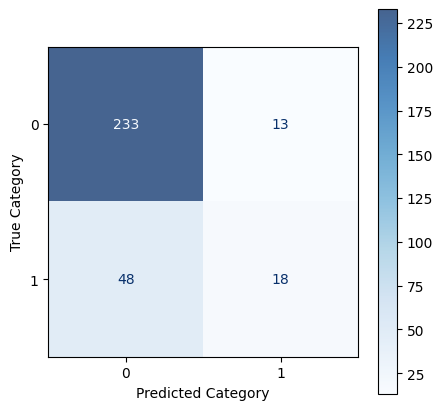

In [289]:
#Visual for the gradiant model
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax,
    im_kw={"cmap": "Blues", "alpha": 0.75}
)
ax.set_xlabel("Predicted Category")
ax.set_ylabel("True Category")
ax.grid(False)
plt.show()